# Optimization Demo

In this notebook, we'll demonstrate optimizing a parameterized version of $\Omega$. We'll assume that we have access to the true data labels for now, although in practice we would of course be working with estimates from a modularity maximization algorithm. 

The particular parameterization we'll use is 
$$\Omega(p;\beta, \gamma) =  n^{-\gamma_k k}\frac{k }{\sum_{j}j^{\beta_k}p_j}\;,$$
where $k = \sum_j p_j$. 
Let's parse this a bit. The term $n^{-\gamma_k k}$ controls the overall density of hyperedges of size $k$. Since the number of *possible* hyperedges scales like $n^k$, we would generally expect $\gamma_k\approx 1$ in a hypergraph in which the number of hyperedges doesn't decrease with size too rapidly, and this is indeed the case in the plots below. 

The second term $$\frac{k}{\sum_{j}j^{\beta_k}p_j}$$ controls the role of homogeneity. When $\beta_k = 0$, this expression is equal to unity. On the other hand, as $\beta_k \rightarrow \infty$, this expression approaches the polyadic $\delta$. The particular form is chosen to add weight to more consolidated groups; for example, if $\beta_k > 0$, then $p = [4, 1, 1]$ will score lower than $p = [4, 2]$ in this term. Heuristically, data sets with more homogeneous edges should have higher values of $\beta_k$. 

Of course, there are many other, likely better choices of parameterization -- this is just a first pass. As the code is currently implemented, we need to represent $\alpha = (\beta, \gamma)$ and then handle some bookkeeping. 

The two code blocks below load modules/scripts and define the functions needed for our experiments, respectively. 

- `initializeExperiment()` loads the data and constructs the function $\Omega$. 
- `optimizeParameters()` is the function that actually performs the optimization. It requires an objective function (i.e. the modularity, regarded as a function of the parameters of $\Omega$), which is returned by `formObjective()` in `inference.jl`. 
- `plotParameters()` calls `initializeExperiment()` and `optimizeParameters()`, and then gives plots of $\beta$ and $\gamma$. 

In [1]:
using StatsBase
using Combinatorics
using Plots
using Optim
using Statistics

include("jl/omega.jl")
include("jl/HSBM.jl")
include("jl/read_data.jl")
include("jl/inference.jl")
include("jl/objectives.jl");

In [2]:
function initializeExperiment(dataset, kmax_)
    """
    read a data set, form Ω using a currently hard-coded functional form, and 
    return important data used in optimizeParameters and plotParameters
    """
    H, Z = read_hypergraph_data(dataset,kmax_)

    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    K = 1:kmax
        
    α0 = vcat(rand(kmax),  1.0 .+ rand(kmax));
    n = 1*length(H.D)

    function ω(p, α)
        k = sum(p)
        return sum(p)/sum((p .* (1:length(p)).^α[k])) / n^(α[kmax+k]*k)
    end
#     function ω(p, α)
#         k = sum(p)
#         return (p[1]/k)^α[k] / n^(α[kmax+k]*k)
#     end

    Ω = buildΩ(ω, α0, kmax)
    
    return(H, Z, Ω, α0, kmin, kmax)
    
end

function optimizeParameters(objective, α0; n_outer = 50, bounds_γ = (-3, 3), bounds_β = (0, 100))
    
    """
    Custom coordinate-wise optimizer. Specific to the functional form used in initializeExperiment().
    In particular, assumes that α = (β, γ), where β controls homogeneity and γ controls size density.  
    """

    α = α0
    kmax = length(α)÷2
    
    res = 0
    
    function inner_obj(α, a, k)
        α_ = copy(α)
        α_[k] = a[1]
        return objective(α_)
    end
    
    for i = 1:n_outer
        # optimization in γ
        for k = (kmax+1):(2*kmax)
            res = optimize(a -> inner_obj(α, a, k), bounds_γ[1], bounds_γ[2]) # very slow and simple -- no gradient information
            α[k] = Optim.minimizer(res)[1]

        end
        # optimization in β
        for k = 1:kmax
            res = optimize(a -> inner_obj(α, a, k), bounds_β[1], bounds_β[2])
            α[k] = Optim.minimizer(res)[1]
        end
    end
    
    ll = -Optim.minimum(res)
    return α, ll
end

function plotParameters(dataset, kmax_)
    """
    wrapper around initializeExperiment(), formObjective(), and optimizeParameters(). 
    Gives output as a basic plot
    """
    
    H, Z, Ω, α0, kmin, kmax = initializeExperiment(dataset, kmax_)
    
    obj = formObjective(H, Z, Ω)
    α, ll = optimizeParameters(obj, α0)
    
    println("$(rpad(dataset, 25, ' ')) : ll = $(round(ll, digits =1))")
    
    β = α[1:kmax]
    γ = α[(kmax+1):(2*kmax)]

    lower_lim = maximum([kmin, 2])

    l = @layout [a ; b]
    p1 = plot(lower_lim:kmax, β[lower_lim:kmax], seriestype = :scatter, label = "", title = dataset)
    ylabel!("β")
    ylims!((0, 1.1*maximum(β[lower_lim:kmax])))
    p2 = plot(lower_lim:kmax, γ[lower_lim:kmax], seriestype = :scatter, label = "", color = "orange")
    ylabel!("γ")
    ylims!((0, 2))
    xlabel!("k")
    p = plot(p1, p2, layout = l)
    return p
end

plotParameters (generic function with 1 method)

Now let's run the code and compare. Currently the optimization can be somewhat slow, so I'd recommend running this for `kmax` no larger than 15 at the moment. 

(note for the future: it would be good to normalize the likelihoods by the effective number of observations, which would allow us to compare the fits on the different data in quantitative fashion. )

congress-bills            : ll = -2.8275625e6
walmart-trips             : ll = -2.4904095e6
TrivagoClickout           : ll = -7.3427356e6
contact-primary-school    : ll = -187328.2


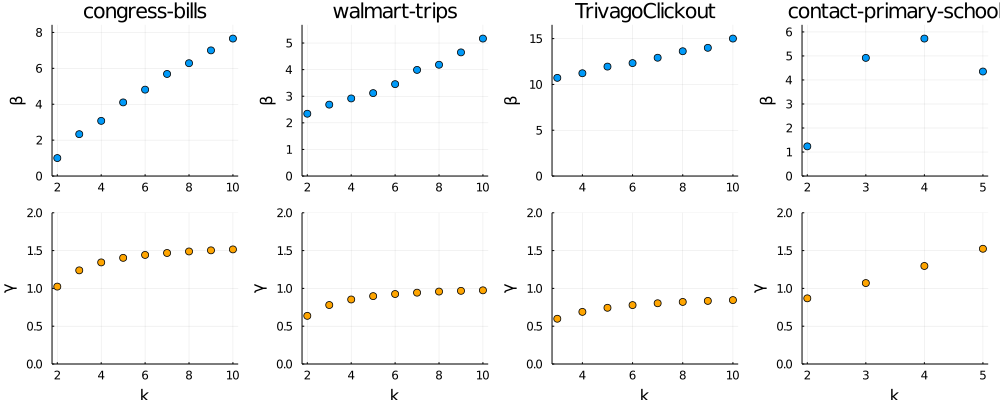

In [3]:
kmax = 10

p1 = plotParameters("congress-bills",         kmax)
p2 = plotParameters("walmart-trips",          kmax)
p3 = plotParameters("TrivagoClickout",        kmax)
p4 = plotParameters("contact-primary-school", kmax)

l = @layout [a b c d]
plot(p1, p2,p3, p4, layout = l, size = (1000, 400))

An important point in this plot relates to the interpretation of $\beta$. In all data sets except `contact-primary-school`, the estimated value $\hat{\beta}_k$ increases with $k$, indicating that the importance of homogeneity increases with $k$. It's necessary to qualify this slightly, as this does **not** mean that edges get more homogeneous as $k$ grows large. This is because the number of possible heterogeneous edges grows faster than the number of possible homogeneous edges as $k$ increases. So, the increasing values of $\hat{\beta}_k$ are actually consistent with small *decreases* in the overall homogeneity of the data. This is shown directly in the descriptive statistics below. 

All this is to say that $\beta$ and $\gamma$ should probably not be *directly* interpreted without some subtle reflection on the structure of the model. It might be best to regard these as non-interpretable parameters whose primary purpose is just to reduce the dimensionality of our problem. 

In [4]:
function plot_descriptives(dataset, kmax_)
    H, Z = read_hypergraph_data(dataset,kmax_)

    kmax = maximum(keys(H.E))
    kmin = minimum(keys(H.E))
    
    sizes = [length(H.E[k]) for k in kmin:kmax]
    
    p1 = plot(collect(kmin:kmax), sizes, seriestype = :scatter, label = "", title = dataset)
    ylabel!("# of edges")
    
    m = repeat([1.0], kmax-kmin+1)
    v = repeat([1.0], kmax-kmin+1)
    for k in kmin:kmax
        if haskey(H.E, k)
            m[k-kmin+1] = sum(partitionize(Z[e])[1]/k*H.E[k][e] for e in keys(H.E[k])) / sum(values(H.E[k]))
            v[k-kmin+1] = sqrt(var(partitionize(Z[e])[1]/k*H.E[k][e] for e in keys(H.E[k])))
        end
    end

    p2 = plot(collect(kmin:kmax), m, seriestype = :scatter, label = "", color = "orange")
    xlabel!("k")
    ylabel!("Plurality density")
    ylims!(0, 1.1)
    
    p3 = plot(collect(kmin:kmax), v, seriestype = :scatter, label = "", color = "purple")
    xlabel!("k")
    ylabel!("Plurality standard deviation")
    
    l = @layout [a ; b ; c]
    p = plot(p1, p2, p3, layout = l)
end

plot_descriptives (generic function with 1 method)

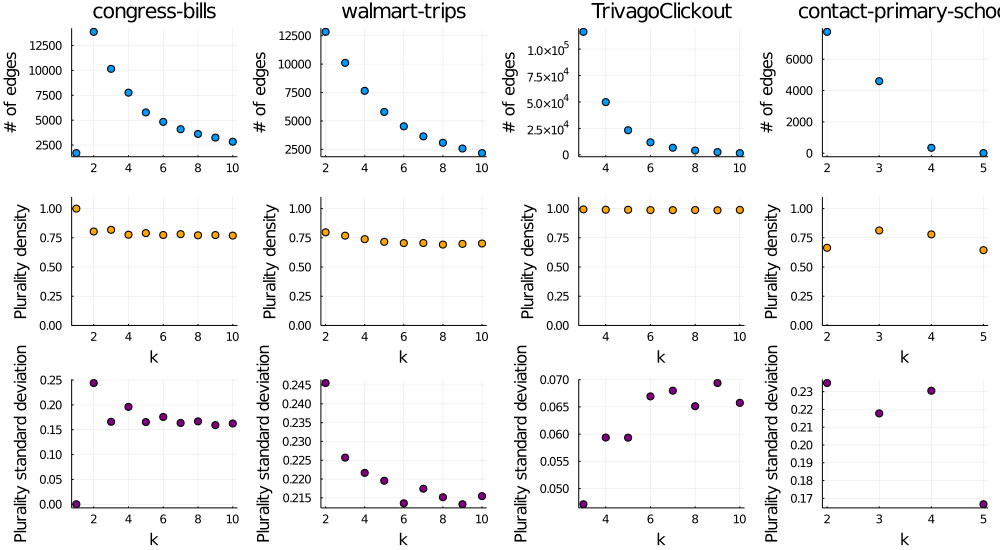

In [5]:
p1 = plot_descriptives("congress-bills",         kmax)
p2 = plot_descriptives("walmart-trips",          kmax)
p3 = plot_descriptives("TrivagoClickout",        kmax)
p4 = plot_descriptives("contact-primary-school", kmax)

l = @layout [a b c d]
plot(p1, p2,p3, p4, layout = l, size = (1000, 550))